# Handling duplicated proxies in a `ProxyDatabase`

Sometimes we may have duplicated proxies in a `ProxyDatabase` whose time series values are highly correlated to each other, which can cause problem for climate field reconstruction algorithms like GraphEM.
Therefore, we need to find and remove the duplicates ahead.
This notebook shows how to achive that goal with the `cfr` utilities.

In [2]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt

## Load a database with duplicated proxies

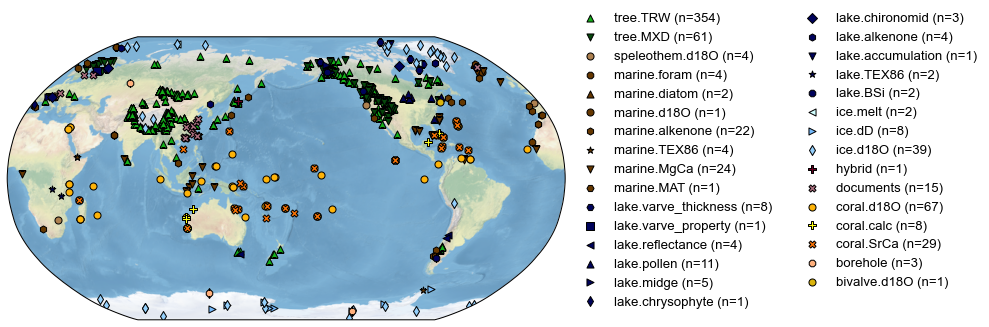

In [3]:
# load a proxy database
job = cfr.ReconJob()
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10_bug.pkl')
fig, ax = job.proxydb.plot()

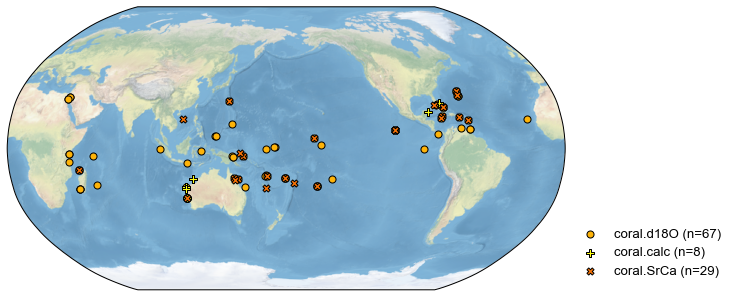

In [4]:
# filter the database
job.proxydb = job.proxydb.filter(by='ptype', keys='coral')
fig, ax = job.proxydb.plot()

In [5]:
job.proxydb = job.proxydb.center([1951, 1980])

Centering each of the ProxyRecord: 100%|██████████| 104/104 [00:00<00:00, 8340.01it/s]


## Find the duplicates

>>> Groups of duplicates:
0 {'Ocn_143', 'Ocn_110', 'Ocn_142', 'Ocn_065', 'Ocn_060'}
1 {'Ocn_156', 'Ocn_075', 'Ocn_157'}
2 {'Ocn_076', 'Ocn_078'}
3 {'Ocn_093', 'Ocn_095', 'Ocn_106', 'Ocn_091'}
4 {'Ocn_096', 'Ocn_127', 'Ocn_125', 'Ocn_178'}
5 {'Ocn_066', 'Ocn_145', 'Ocn_144', 'Ocn_067'}
6 {'Ocn_114', 'Ocn_158', 'Ocn_153'}
7 {'Ocn_151', 'Ocn_149', 'Ocn_150', 'Ocn_112', 'Ocn_111', 'Ocn_152'}
8 {'Ocn_129', 'Ocn_103', 'Ocn_177', 'Ocn_107', 'Ocn_098'}
9 {'Ocn_080', 'Ocn_082'}
10 {'Ocn_173', 'Ocn_171'}
11 {'Ocn_108', 'Ocn_182', 'Ocn_181'}
12 {'Ocn_116', 'Ocn_115'}
13 {'Ocn_118', 'Ocn_170', 'Ocn_172', 'Ocn_174'}
14 {'Ocn_180', 'Ocn_166', 'Ocn_097', 'Ocn_090', 'Ocn_179'}
15 {'Ocn_154', 'Ocn_155'}
16 {'Ocn_131', 'Ocn_130'}
17 {'Ocn_083', 'Ocn_077', 'Ocn_062', 'Ocn_061', 'Ocn_139'}
18 {'Ocn_160', 'Ocn_162', 'Ocn_161', 'Ocn_119', 'Ocn_159', 'Ocn_104', 'Ocn_163'}
19 {'Ocn_122', 'Ocn_164', 'Ocn_183', 'Ocn_165'}
20 {'Ocn_120', 'Ocn_121'}
>>> Hint for the next step:
Use the method `.sequeeze_dups(pids_

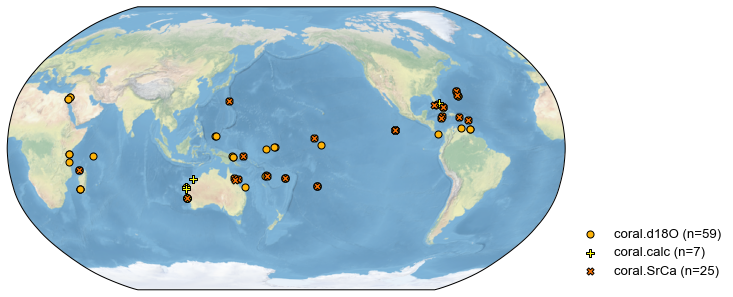

In [6]:
# r_thresh = 0.9 by default, R >= r_thresh will be regarded as dupilicates
pdb_dups = job.proxydb.find_duplicates(r_thresh=0.9, time_period=[1001, 2000])
fig, ax = pdb_dups.plot()

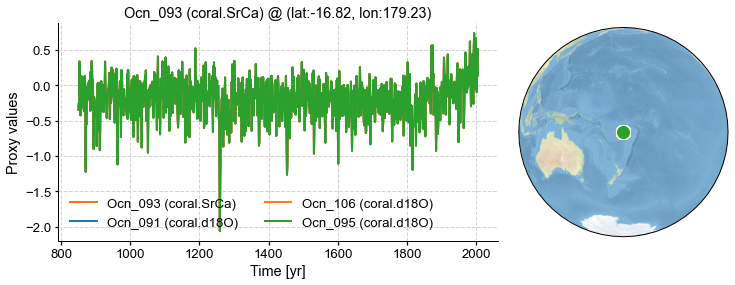

In [7]:
fig, ax = pdb_dups.records['Ocn_093'].plot_dups(lgd_kws={'ncol': 2})

In [8]:
# squeeze the dupilicates manually
# pids_to_keep = ['Ocn_178', 'Ocn_106', 'Ocn_179', 'Ocn_160', 'Ocn_170', 'Ocn_076', 'Ocn_082', 'Ocn_181', 'Ocn_164', 'Ocn_121', 'Ocn_130', 'Ocn_083', 'Ocn_143', 'Ocn_116', 'Ocn_158', 'Ocn_066', 'Ocn_150', 'Ocn_103', 'Ocn_154', 'Ocn_075', 'Ocn_171']
# pdb_to_keep = pdb_dups.squeeze_dups(pids_to_keep=pids_to_keep)

In [10]:
# squeeze the dupilicates automatically
pdb_to_keep = pdb_dups.squeeze_dups()

>>> Note: since `pids_to_keep` is not specified, the first of each group of the duplicates is picked.
>>> pids to keep (n=21):
{'Ocn_120', 'Ocn_118', 'Ocn_154', 'Ocn_108', 'Ocn_180', 'Ocn_093', 'Ocn_160', 'Ocn_173', 'Ocn_129', 'Ocn_122', 'Ocn_151', 'Ocn_116', 'Ocn_143', 'Ocn_080', 'Ocn_076', 'Ocn_066', 'Ocn_114', 'Ocn_083', 'Ocn_096', 'Ocn_131', 'Ocn_156'}


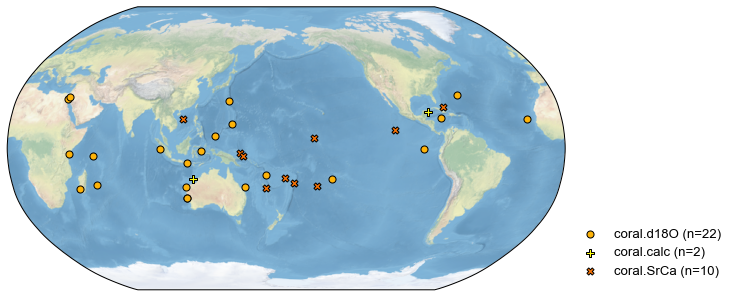

In [11]:
# update the proxy database, excluding duplicates
job.proxydb = job.proxydb - pdb_dups + pdb_to_keep
fig, ax = job.proxydb.plot()

## Test GraphEM

In [12]:
# load observations
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


In [13]:
# regrid and crop obs to make the problem size smaller
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
#job.regrid_clim(tag='obs', nlat=32, nlon=50, verbose=True)
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


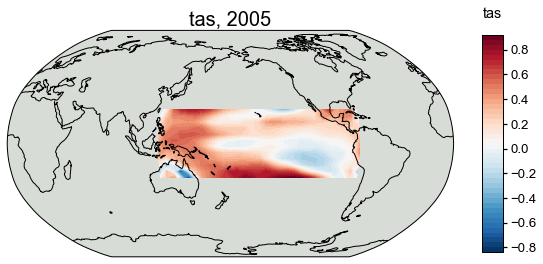

In [14]:
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))
fig, ax = job.obs['tas'].plot(it=-1)

In [15]:
job.prep_graphem(
    recon_period=(1001, 2000),
    calib_period=(1850, 2000),
    verbose=True)

>>> job.recon_time created
>>> job.calib_time created
>>> job.calib_idx created
>>> job.temp created
>>> job.df_proxy created
>>> job.proxy created
>>> job.lonlat created


In [16]:
job.df_proxy

,Ocn_167,Ocn_086,Ocn_101,Ocn_099,Ocn_088,Ocn_084,Ocn_073,Ocn_081,Ocn_074,Ocn_079,...,Ocn_160,Ocn_122,Ocn_066,Ocn_143,Ocn_129,Ocn_114,Ocn_120,Ocn_173,Ocn_118,Ocn_156
1001.0,0.898822,0.029546,-0.185165,0.235898,-0.366383,-0.826732,-0.571113,-0.543309,-0.095079,0.098754,...,-0.756506,0.179718,-0.019820,-0.265143,-0.858049,-0.348730,1.130590,-0.037313,-0.931678,-0.205720
1002.0,-0.215733,-0.366285,-0.751944,-0.589594,-0.709740,-0.668547,-0.485664,-0.540698,-0.451790,-0.538710,...,-0.212252,-0.567023,-0.114183,-0.381510,-0.143228,-0.293169,0.293682,-0.840724,-0.809721,-0.380234
1003.0,0.439043,-0.243331,-0.202119,-0.514341,-0.279519,-0.006054,-0.114589,-0.200504,-0.160557,-0.195342,...,-0.067308,-0.563551,0.034984,-0.021775,-0.137066,0.440870,0.657985,0.200977,0.979280,0.186897
1004.0,0.381423,0.171702,0.404180,0.157582,-0.006598,-0.132344,-0.316654,-0.406022,0.001588,0.055546,...,-0.416455,0.389121,-0.348566,-0.402199,-0.478888,-0.066871,0.609900,-0.188294,-0.210162,-0.023028
1005.0,0.186128,-0.152617,-0.247644,0.170491,-0.276179,0.046075,-0.216756,-0.488320,-0.420469,0.045561,...,-0.461959,-0.503078,0.009681,0.106184,-0.478050,-0.108365,0.267414,-0.544992,-0.316079,-0.203502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996.0,0.143895,-0.030944,0.308333,-0.109840,0.076432,0.443499,0.558331,0.614777,0.096091,0.041014,...,0.497055,0.409301,0.350579,0.618679,0.774288,0.888607,0.022645,0.487655,1.645176,0.291426
1997.0,-0.058669,0.313273,0.388179,0.635640,0.525582,0.533289,0.101198,-0.003772,0.318022,0.687141,...,0.012817,0.532770,0.475388,0.148711,0.116460,0.074774,-0.608476,0.016154,-0.084373,0.197638
1998.0,-0.710221,0.194011,0.340377,0.177812,0.236113,0.547631,0.441170,0.307208,0.275842,0.258968,...,0.680764,0.004766,0.740061,0.363143,0.748480,0.525448,-0.417760,0.337575,0.431329,0.620285
1999.0,0.114631,0.322021,0.886320,0.398480,0.265992,0.703740,0.573262,0.770644,0.169370,0.102518,...,0.386616,0.314544,0.410695,0.529297,0.538393,0.587975,-0.128660,0.131140,0.875070,0.049518


In [17]:
%%time
# need to remove G.pkl if the previous run is problematic
save_path = './results/graphem-ppe-pages2k-dups/G.pkl'
job.run_graphem(
    save_path=save_path,
    load_precalculated=False,
    verbose=True,
)

Computing a neighborhood graph with R = 1000.0 km
Estimating graph using neighborhood method
Running GraphEM:

Iter     dXmis     rdXmis

001     0.0537     0.7804
002     0.0662     0.7511
003     0.0775     0.6915
004     0.0629     0.3537
005     0.0464     0.1981
006     0.0388     0.1417
007     0.0359     0.1177
008     0.0347     0.1042
009     0.0343     0.0955
010     0.0342     0.0887
011     0.0332     0.0806
012     0.0324     0.0743
013     0.0305     0.0664
014     0.0283     0.0588
015     0.0265     0.0530
016     0.0230     0.0445
017     0.0207     0.0389
018     0.0181     0.0333
019     0.0156     0.0282
020     0.0149     0.0265
021     0.0146     0.0256
022     0.0147     0.0256
023     0.0130     0.0224
024     0.0119     0.0204
025     0.0111     0.0189
026     0.0124     0.0211
027     0.0111     0.0189
028     0.0103     0.0175
029     0.0097     0.0164
030     0.0092     0.0156
031     0.0088     0.0148
032     0.0084     0.0142
033     0.0080     0.0136
034 

In [18]:
mask = (job.obs['tas'].time >= 1001) & (job.obs['tas'].time <= 2000)
target = job.obs['tas'].da.values[mask]
print(np.shape(target))

nt = job.recon.shape[0]
temp_r = job.recon.reshape((nt, -1))
V = cfr.graphem.solver.verif_stats(temp_r, target.reshape((nt, -1)), job.calib_idx)
print(V)

(1000, 12, 28)
Mean MSE = 0.1726, Mean RE = 0.3244, Mean CE = 0.2426, Mean R2 = 0.5177
